In [2]:
#Import the required libraries
from contextlib import suppress

with suppress(Exception):import numpy as np
np.random.seed(1338)

from keras.datasets import mnist

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

In [4]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

In [5]:
from keras.utils import np_utils
from keras.optimizers import SGD

In [6]:
#Load the training and testing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [7]:
X_test_orig = X_test

In [8]:
#Data Preparation
from keras import backend as K

In [9]:
#When dealing with images & convolutions, it is paramount to handle image_data_format properly
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

In [10]:
#Preprocess and Normalise Data
X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [11]:
np.random.seed(1338)  # for reproducibilty!!

# Test data
X_test = X_test.copy()
Y = y_test.copy()

# Converting the output to binary classification(Six=1,Not Six=0)
Y_test = Y == 6
Y_test = Y_test.astype(int)

# Selecting the 5918 examples where the output is 6
X_six = X_train[y_train == 6].copy()
Y_six = y_train[y_train == 6].copy()

# Selecting the examples where the output is not 6
X_not_six = X_train[y_train != 6].copy()
Y_not_six = y_train[y_train != 6].copy()

# Selecting 6000 random examples from the data that 
# only contains the data where the output is not 6
random_rows = np.random.randint(0,X_six.shape[0],6000)
X_not_six = X_not_six[random_rows]
Y_not_six = Y_not_six[random_rows]

In [12]:
# Appending the data with output as 6 and data with output as <> 6
X_train = np.append(X_six,X_not_six)

# Reshaping the appended data to appropraite form
X_train = X_train.reshape((X_six.shape[0] + X_not_six.shape[0],) + shape_ord)

# Appending the labels and converting the labels to 
# binary classification(Six=1,Not Six=0)
Y_labels = np.append(Y_six,Y_not_six)
Y_train = Y_labels == 6 
Y_train = Y_train.astype(int)

In [13]:
print(X_train.shape, Y_labels.shape, X_test.shape, Y_test.shape)

(11918, 28, 28, 1) (11918,) (10000, 28, 28, 1) (10000,)


In [14]:
# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

In [15]:
#A simple CNN
# -- Initializing the values for the convolution neural network

nb_epoch = 2  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

In [16]:
#Step 1: Model Definition
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 43266     
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 43,586
Trainable params: 43,586
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Step 2: Compile
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [19]:
#Step 3: Fit
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 7s - loss: 0.2321 - acc: 0.9491 - val_loss: 0.1276 - val_acc: 0.9616
Epoch 2/2
11918/11918 [==============================] - 6s - loss: 0.1065 - acc: 0.9666 - val_loss: 0.0933 - val_acc: 0.9685


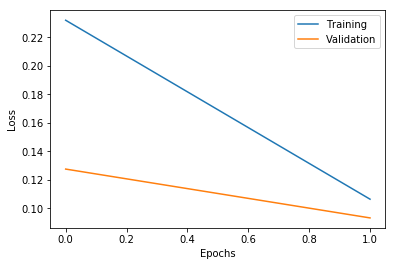

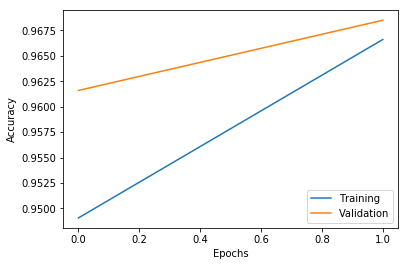

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

In [21]:
#Step 4: Evaluate
print('Available Metrics in Model: {}'.format(model.metrics_names))

Available Metrics in Model: ['loss', 'acc']


In [22]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.09332812897264957
Test Accuracy: 0.9685


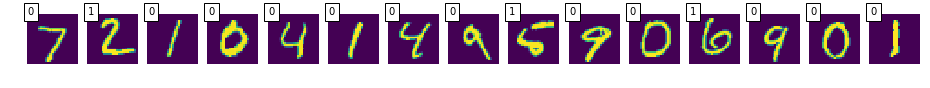

In [23]:
#Let's plot our model Predictions!
import matplotlib.pyplot as plt

%matplotlib inline
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

In [24]:
#Adding more Dense Layers
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2769024   
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total para

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 16s - loss: 0.1963 - acc: 0.9456 - val_loss: 0.0869 - val_acc: 0.9720
Epoch 2/2
11918/11918 [==============================] - 15s - loss: 0.0897 - acc: 0.9707 - val_loss: 0.0889 - val_acc: 0.9686


In [27]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.0889299758270383
Test accuracy: 0.9686


In [29]:
#Adding Dropout
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                        padding='valid',
                        input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2769024   
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
__________

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 16s - loss: 0.2460 - acc: 0.9344 - val_loss: 0.1817 - val_acc: 0.9355
Epoch 2/2
11918/11918 [==============================] - 16s - loss: 0.1058 - acc: 0.9653 - val_loss: 0.0973 - val_acc: 0.9651


In [33]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.0972900361686945
Test accuracy: 0.9651


In [38]:
#Adding more Convolution Layers

model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_13 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
__________

In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 33s - loss: 0.4018 - acc: 0.8444 - val_loss: 0.1562 - val_acc: 0.9556
Epoch 2/2
11918/11918 [==============================] - 34s - loss: 0.1368 - acc: 0.9568 - val_loss: 0.0919 - val_acc: 0.9688


In [41]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.09191594836264849
Test accuracy: 0.9688


In [43]:
# Function for constructing the convolution neural network

def build_model():
    """"""
    model = Sequential()
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv), 
                     padding='valid',
                     input_shape=shape_ord))
    model.add(Activation('relu'))
    model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=nb_epoch,verbose=1,
              validation_data=(X_test, Y_test))
          

    #Evaluating the model on the test data    
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score)
    print('Test accuracy:', accuracy)

In [44]:
#Timing how long it takes to build the model and test it.
%timeit -n1 -r1 build_model()

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 32s - loss: 0.3686 - acc: 0.8590 - val_loss: 0.1740 - val_acc: 0.9391
Epoch 2/2
11918/11918 [==============================] - 35s - loss: 0.1460 - acc: 0.9494 - val_loss: 0.1127 - val_acc: 0.9609
Test score: 0.11274162018597127
Test accuracy: 0.9609
1min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
#Batch Normalisation
#Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains 
#the mean activation close to 0 and the activation standard deviation close to 1.
